In [3]:
# ===============================
# Notebook : A/B Test Causal ML
# ===============================

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns




In [4]:

# -------------------------------
#  Créer un dataset simulé
np.random.seed(42)
n = 1000

df = pd.DataFrame({
    'age': np.random.randint(18, 60, n),
    'income': np.random.randint(20000, 100000, n),
    'historical_purchase': np.random.normal(500, 50, n)
})


In [5]:

# -------------------------------
# Assigner le traitement aléatoirement (A/B test)
df['treatment'] = np.random.binomial(1, 0.5, n)

# Simuler l'effet de la pub sur purchase
df['purchase'] = df['historical_purchase'] + 100*df['treatment'] + np.random.normal(0, 20, n)


In [6]:

# -------------------------------
# Vérification randomisation
print("Moyennes par groupe :")
print(df.groupby('treatment')[['age','income','historical_purchase','purchase']].mean())


Moyennes par groupe :
                 age        income  historical_purchase    purchase
treatment                                                          
0          38.745303  59979.526096           500.542510  501.506359
1          38.744722  60494.936660           501.859032  600.857687


In [7]:

# -------------------------------
#  Estimation du Propensity Score
X = df[['age','income','historical_purchase']]
y = df['treatment']

ps_model = LogisticRegression()
ps_model.fit(X, y)
df['ps'] = ps_model.predict_proba(X)[:,1]




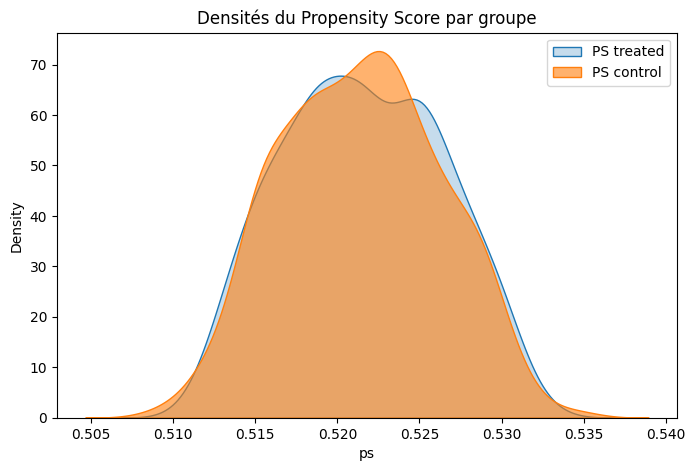

In [8]:
# Vérifier overlap
plt.figure(figsize=(8,5))
sns.kdeplot(df.loc[df['treatment']==1,'ps'], label='PS treated', fill=True)
sns.kdeplot(df.loc[df['treatment']==0,'ps'], label='PS control', fill=True, alpha=0.6)
plt.title('Densités du Propensity Score par groupe')
plt.legend()
plt.show()

In [9]:

# -------------------------------
#  Estimation ATE via Matching
treated = df[df['treatment']==1].reset_index(drop=True)
control = df[df['treatment']==0].reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['ps']])
dist, idx = nn.kneighbors(treated[['ps']])
matched_control = control.iloc[idx.flatten()].reset_index(drop=True)

ate_matched = (treated['purchase'].values - matched_control['purchase'].values).mean()
print('ATE (Matching simple):', ate_matched)


ATE (Matching simple): 96.71244609605739


In [10]:

# -------------------------------
#  Estimation ATE via IPW
p_t = df['treatment'].mean()
df['w_stab'] = np.where(df['treatment']==1, p_t/df['ps'], (1-p_t)/(1-df['ps']))

ate_ipw = (df[df['treatment']==1]['purchase'] * df[df['treatment']==1]['w_stab']).sum() / df[df['treatment']==1]['w_stab'].sum() \
        - (df[df['treatment']==0]['purchase'] * df[df['treatment']==0]['w_stab']).sum() / df[df['treatment']==0]['w_stab'].sum()
print('ATE (IPW stabilisé):', ate_ipw)


ATE (IPW stabilisé): 99.02037855488743


In [11]:
import numpy as np
print(np.__version__)


2.2.6


In [1]:
# Pour Causal ML
econml_available = False
try:
    from econml.dml import CausalForestDML
    from sklearn.ensemble import RandomForestRegressor
    econml_available = True
except Exception as e:
    print('econml import failed:', e)
    print('\nTo install econml, run: pip install econml --no-binary econml')

In [13]:

# -------------------------------
# Causal Forest (CATE individuels)
if econml_available:
    T = df['treatment'].values
    Y = df['purchase'].values
    W = df[['age','income','historical_purchase']].values

    est = CausalForestDML(
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_y=RandomForestRegressor(n_estimators=200, min_samples_leaf=5),
        n_estimators=200,
        random_state=42
    )

    est.fit(Y, T, X=W)
    ate_cf = est.ate(X=W)
    print('CausalForest ATE:', ate_cf)

    # CATE pour les 10 premiers clients
    cates = est.effect(X=W[:10])
    print('Premiers 10 CATEs:', cates)

    # Ajouter CATE dans dataframe
    df['CATE'] = est.effect(X=W)



CausalForest ATE: 99.55950175296182
Premiers 10 CATEs: [ 93.82530361  97.63526266 102.26316758 100.22164816 105.43027854
  99.85052412 100.0047958   92.39011414  99.64502433 105.71125166]


In [14]:
df.columns

Index(['age', 'income', 'historical_purchase', 'treatment', 'purchase', 'ps',
       'w_stab', 'CATE'],
      dtype='object')

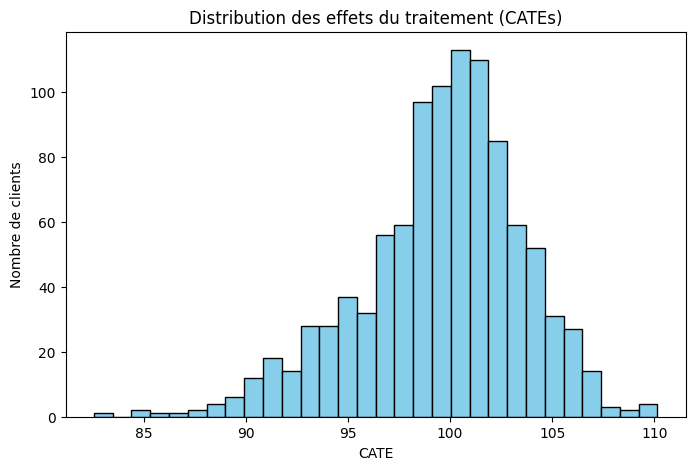

In [15]:
# -------------------------------
#  Visualiser distribution des CATEs
if 'CATE' in df.columns:
    plt.figure(figsize=(8,5))
    plt.hist(df['CATE'], bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution des effets du traitement (CATEs)")
    plt.xlabel("CATE")
    plt.ylabel("Nombre de clients")
    plt.show()



In [18]:

# -------------------------------
# 10️⃣ Identifier clients avec effet positif
if 'CATE' in df.columns:
    positive_clients = df[df['CATE']>90]
    print(f"Nombre de clients avec effet positif: {len(positive_clients)}")

Nombre de clients avec effet positif: 981
